In [1]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.svm import OneClassSVM
from sklearn.cluster import DBSCAN

from sklearn.metrics import precision_recall_curve, auc, roc_curve

In [2]:
# Generate date range and synthetic time series data
np.random.seed(123)
dates = pd.date_range('2020-01-01', periods=100, freq='D')
data = pd.DataFrame(np.random.randn(100) + np.sin(np.linspace(0, 10, 100)) * 2, 
                    columns=["value"], index=dates)

# Introduce 5 anomalies
anomaly_indices = np.random.choice(data.index, size=5, replace=False)
data.loc[anomaly_indices, 'value'] += np.random.choice([10, -10], size=5)  # Add anomalies

# Mark anomalies in a new column
data['true_anomaly'] = 0
data.loc[anomaly_indices, 'true_anomaly'] = 1
data['true_anomaly'] = data['true_anomaly'].map({0: False, 1: True})

data.head()

,value,true_anomaly
2020-01-01,-11.085631,True
2020-01-02,1.199022,False
2020-01-03,0.684276,False
2020-01-04,-0.909467,False
2020-01-05,0.207673,False


In [3]:
# Filter rows where 'true_anomaly' is True (i.e., anomalies)
anomalies = data[data['true_anomaly'] == True]
display(anomalies)

,value,true_anomaly
2020-01-01,-11.085631,True
2020-01-15,11.531527,True
2020-01-21,-7.461221,True
2020-02-09,-11.148018,True
2020-03-20,10.378228,True


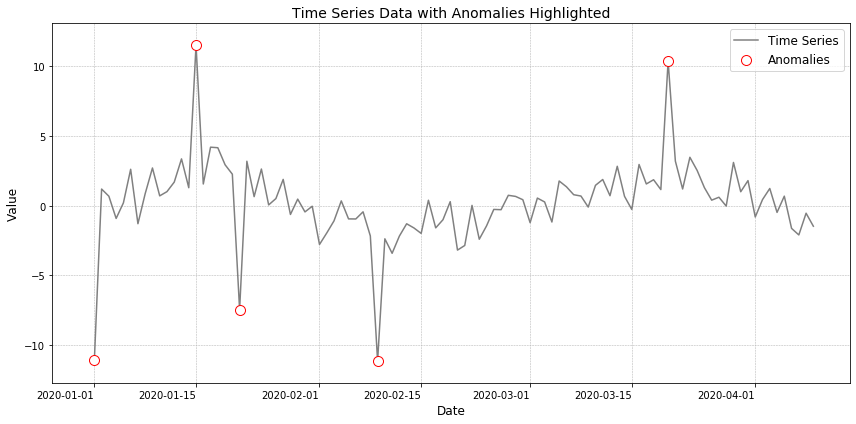

In [4]:
# Visualize the time series data with anomalies highlighted
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='Time Series', color='gray')


plt.scatter(anomalies.index, anomalies['value'], color='white', label='Anomalies', zorder=5, s=100, edgecolors='red')

plt.title('Time Series Data with Anomalies Highlighted', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=0, ha='right')
plt.tight_layout()
plt.show()

In [5]:
# Anomaly Detection using Isolation Forest

# standardize the value amounts
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data[['value']])

#  Apply Isolation Forest for Anomaly Detection
model = IsolationForest(
    n_estimators=100,          # Number of trees in the forest
    contamination=0.05,        # Contamination factor (expected percentage of anomalies)
    max_samples=256,           # Number of samples to train each tree on (use a fraction if dataset is large)
    random_state=123,          # Ensure reproducibility
    max_features=1.0,          # Use all features 
    bootstrap=False,           # Use bootstrapping (False for faster training)
    n_jobs=-1,                 # Use all cores for parallel computation
    warm_start=False           # Option to add data incrementally (can be set True for large datasets)
)

anomalies = model.fit_predict(data_scaled)

# Convert the anomaly labels (-1 for anomaly, 1 for normal)
data['anomaly'] = anomalies
data['anomaly'] = data['anomaly'].map({1: False, -1: True})

data.head()

,value,true_anomaly,anomaly
2020-01-01,-11.085631,True,True
2020-01-02,1.199022,False,False
2020-01-03,0.684276,False,False
2020-01-04,-0.909467,False,False
2020-01-05,0.207673,False,False


In [6]:
# Analyze the Detected Anomalies
anomalous_values = data[data['anomaly'] == True]
print("\nAnomalous values Detected:")
anomalous_values


Anomalous values Detected:


,value,true_anomaly,anomaly
2020-01-01,-11.085631,True,True
2020-01-15,11.531527,True,True
2020-01-21,-7.461221,True,True
2020-02-09,-11.148018,True,True
2020-03-20,10.378228,True,True


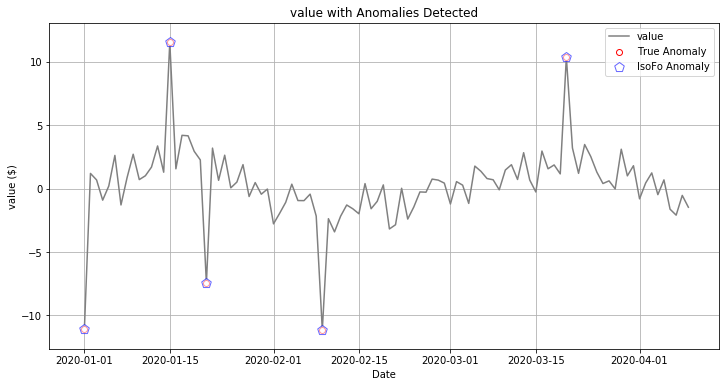

In [16]:
# Visualize the Anomalies in the Data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='value', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['value'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['anomaly']], data['value'][data['anomaly']], color='white', label='IsoFo Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='p', alpha=0.6)
plt.title('value with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('value ($)')
plt.grid(True)
plt.legend()
plt.show()

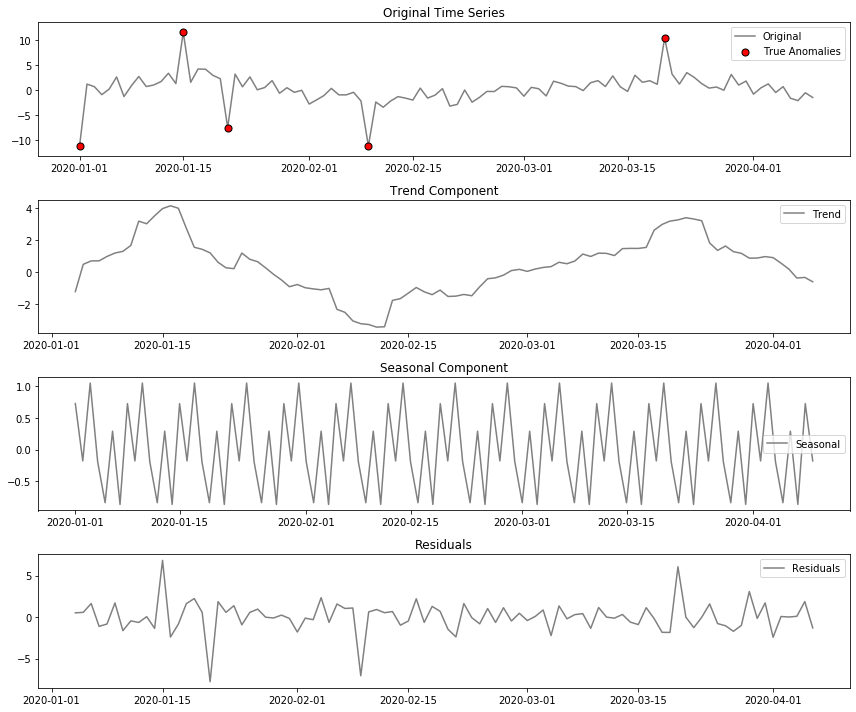

In [17]:
# Perform seasonal decomposition
period = 7  # Weekly seasonality as an example
decomposition = seasonal_decompose(data['value'], model='additive', period=period)

# Plot seasonal decomposition results
plt.figure(figsize=(12, 10))

# Original Time Series with True Anomalies Highlighted
plt.subplot(411)
plt.plot(data['value'], label='Original', color='gray')
anomalies = data[data['true_anomaly'] == True]
plt.scatter(anomalies.index, anomalies['value'], color='red', label='True Anomalies', 
            zorder=5, s=50, edgecolors='black')
plt.title('Original Time Series')
plt.legend()

# Trend Component
plt.subplot(412)
plt.plot(decomposition.trend, label='Trend', color='gray')
plt.title('Trend Component')
plt.legend()

# Seasonal Component
plt.subplot(413)
plt.plot(decomposition.seasonal, label='Seasonal', color='gray')
plt.title('Seasonal Component')
plt.legend()

# Residual Component
plt.subplot(414)
plt.plot(decomposition.resid, label='Residuals', color='gray')
plt.title('Residuals')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
# Detect Anomalies Using Seasonal Decomposition
period = 7  
decomposition = seasonal_decompose(data['value'], model='additive', period=period)

# Get the residual component (the "noise" part)
residuals = decomposition.resid

# Define a threshold to detect anomalies in the residuals (e.g., points beyond 2 standard deviations)
threshold = 2 * np.std(residuals)

# Identify anomalies where residuals exceed the threshold
anomalies_residual = np.abs(residuals) > threshold

# Add the detected anomalies to the data (True for anomalies, False for normal points)
data['residual_anomaly'] = anomalies_residual

display(data.head())

# Display the data with detected anomalies
display(data[data['residual_anomaly'] == True])

,value,true_anomaly,anomaly,residual_anomaly
2020-01-01,-11.085631,True,True,False
2020-01-02,1.199022,False,False,False
2020-01-03,0.684276,False,False,False
2020-01-04,-0.909467,False,False,False
2020-01-05,0.207673,False,False,False


,value,true_anomaly,anomaly,residual_anomaly
2020-01-15,11.531527,True,True,True
2020-01-21,-7.461221,True,True,True
2020-02-09,-11.148018,True,True,True
2020-03-20,10.378228,True,True,True


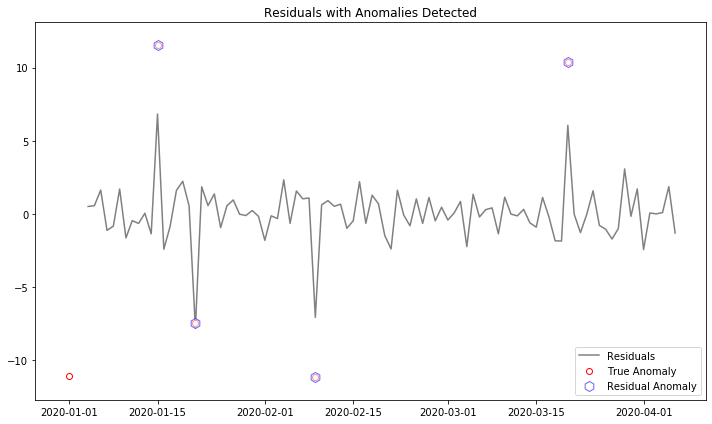

In [21]:
# Plot the residual decomposition results and anomalies
plt.figure(figsize=(10, 6))

# Residual Component with Anomalies Highlighted
plt.plot(decomposition.resid, label='Residuals', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['value'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['residual_anomaly']], data['value'][data['residual_anomaly']], color='white', label='Residual Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='h', alpha=0.6)
plt.title('Residuals with Anomalies Detected')
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

One-Class SVM

In [11]:
# Standardize the data 
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data[['value']])

# Define the One-Class SVM model with additional options
ocsvm = OneClassSVM(
    kernel='rbf',           # Use Radial Basis Function (RBF) kernel
    nu=0.1,                 # Set the fraction of outliers to 5%
#   gamma='scale',          # Automatically scale gamma based on data
    gamma=0.05,             # A lower gamma value reduces the sensitivity of the model 
#   degree=3,               # Degree of the polynomial kernel (if used)
#   coef0=0.0,              # Constant for polynomial or sigmoid kernels
    shrinking=True,         # Use shrinking heuristic for faster convergence
    max_iter=-1             # No limit on iterations
)

# Fit the model and detect anomalies
ocsvm_anomalies = ocsvm.fit_predict(data_scaled)

# Convert the anomaly labels to boolean (True for anomalies, False for normal points)
data['ocsvm_anomaly'] = ocsvm_anomalies == -1

# Display the data with detected anomalies
display(data.head())

# Display the detected anomalies
display(data[data['ocsvm_anomaly'] == True])

,value,true_anomaly,anomaly,residual_anomaly,ocsvm_anomaly
2020-01-01,-11.085631,True,True,False,True
2020-01-02,1.199022,False,False,False,False
2020-01-03,0.684276,False,False,False,False
2020-01-04,-0.909467,False,False,False,False
2020-01-05,0.207673,False,False,False,False


,value,true_anomaly,anomaly,residual_anomaly,ocsvm_anomaly
2020-01-01,-11.085631,True,True,False,True
2020-01-15,11.531527,True,True,True,True
2020-01-17,4.203872,False,False,False,True
2020-01-18,4.165399,False,False,False,True
2020-01-21,-7.461221,True,True,True,True
2020-02-09,-11.148018,True,True,True,True
2020-02-11,-3.410419,False,False,False,True
2020-03-20,10.378228,True,True,True,True
2020-03-23,3.479844,False,False,False,True


In [12]:
# Calculate the decision function (distance from the decision boundary)
decision_scores = ocsvm.decision_function(data_scaled)

# If the decision score is above a certain threshold, mark as normal; else anomaly
threshold = np.percentile(decision_scores, 5)  # Adjust the threshold to reduce anomalies
data['ocsvm_anomaly'] = decision_scores < threshold

# Display detected anomalies
data[data['ocsvm_anomaly'] == True]

,value,true_anomaly,anomaly,residual_anomaly,ocsvm_anomaly
2020-01-01,-11.085631,True,True,False,True
2020-01-15,11.531527,True,True,True,True
2020-01-21,-7.461221,True,True,True,True
2020-02-09,-11.148018,True,True,True,True
2020-03-20,10.378228,True,True,True,True


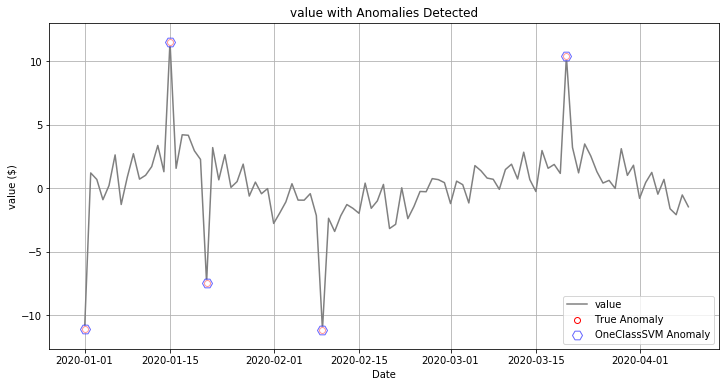

In [22]:
# Visualize the OneClassSVM Anomalies in the Data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='value', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['value'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['ocsvm_anomaly']], data['value'][data['ocsvm_anomaly']], color='white', label='OneClassSVM Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='H', alpha=0.6)
plt.title('value with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('value ($)')
plt.grid(True)
plt.legend()
plt.show()

DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

In [14]:
# Standardize the data
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data[['value']])

# Define the DBSCAN model
dbscan = DBSCAN(
    eps=0.5,            # Maximum distance between two points to be considered neighbors
    min_samples=5,      # Minimum number of points to form a dense region (core points)
    metric='euclidean', # Distance metric
    n_jobs=-1           # Use all CPU cores for parallel computation
)

# Fit DBSCAN model to the scaled data
dbscan_labels = dbscan.fit_predict(data_scaled)

# Convert the labels to boolean (True for anomalies, False for normal points)
# Points labeled as -1 are anomalies in DBSCAN
data['dbscan_anomaly'] = dbscan_labels == -1

# Display the data with detected anomalies
display(data.head())

# Display detected anomalies
display(data[data['dbscan_anomaly'] == True])

,value,true_anomaly,anomaly,residual_anomaly,ocsvm_anomaly,dbscan_anomaly
2020-01-01,-11.085631,True,True,False,True,True
2020-01-02,1.199022,False,False,False,False,False
2020-01-03,0.684276,False,False,False,False,False
2020-01-04,-0.909467,False,False,False,False,False
2020-01-05,0.207673,False,False,False,False,False


,value,true_anomaly,anomaly,residual_anomaly,ocsvm_anomaly,dbscan_anomaly
2020-01-01,-11.085631,True,True,False,True,True
2020-01-15,11.531527,True,True,True,True,True
2020-01-21,-7.461221,True,True,True,True,True
2020-02-09,-11.148018,True,True,True,True,True
2020-03-20,10.378228,True,True,True,True,True


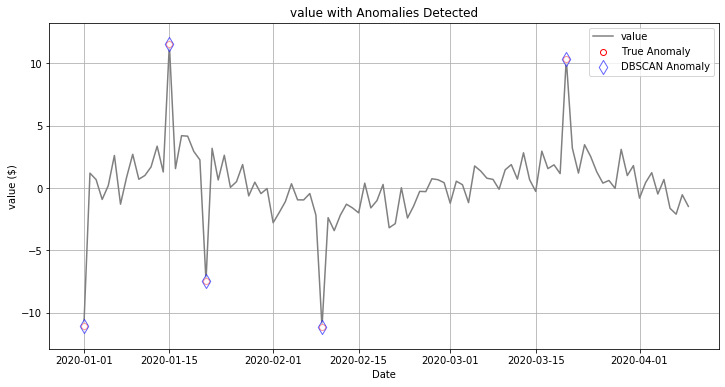

In [23]:
# Visualize the DBSCAN Anomalies in the Data
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['value'], label='value', color='gray')
plt.scatter(data.index[data['true_anomaly']], data['value'][data['true_anomaly']], color='white',
            label='True Anomaly', zorder=5, edgecolors='red')
plt.scatter(data.index[data['dbscan_anomaly']], data['value'][data['dbscan_anomaly']], color='white', label='DBSCAN Anomaly',
            zorder=5, s=100, edgecolors='blue', marker='d', alpha=0.6)
plt.title('value with Anomalies Detected')
plt.xlabel('Date')
plt.ylabel('value ($)')
plt.grid(True)
plt.legend()
plt.show()